In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
assert torch.cuda.is_available

# Problem 1
Create the device variable.
Download the CIFAR10 training and test datasets.
Transform them into tensors and normalize them.

In [ ]:
#create the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#create the transformation
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))])

#get the training data and transform it
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [ ]:
#get the test data and transform it
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=transform)

Files already downloaded and verified


# Problem 2
Split the data into train, validation, and test sets, and create DataLoaders for each one. Use a batch size of 32 for the training set and 1 for the validation and test sets.

In [ ]:
#separate into training and validation
actual_train_data = [train_data[i] for i in range(40_000)]
validation_data = [train_data[j] for j in range(40_000,50_000)]

#create DataLoaders for each data type
train_loader = DataLoader(actual_train_data, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=1, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# Problem 3

Create a class for a convolutional neural network that accepts images as $3\times 32 \times 32$ tensors and returns a 1D tensor of length 10, representing its predicted probabilities of each class.

The model should have at least three convolution layers, each followed by an activation function, a max pooling layer, and at least two linear layers.
Be sure that your final activation function is the softmax function.
Choose the size of the layers so that your model has at least 50,000 parameters, and record this calculation in the Jupyter notebook.

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [ ]:
class max_nn(nn.Module):
  def __init__(self):
    # Initialize nn.Module
    super().__init__()
    #count the number of parameters
    self.nparams = 0
    #create the various functions
    self.flatten = nn.Flatten()
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

    #create the convolution layers
    self.convo_layer1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
    self.nparams += (3*9+1)*8

    self.convo_layer2 = nn.Conv2d(in_channels=8, out_channels=10, kernel_size=3)
    self.nparams += (8*9+1)*10

    self.convo_layer3 = nn.Conv2d(in_channels=10, out_channels=12, kernel_size=3)
    self.nparams += (10*9+1)*12

    #create the max pool layer
    self.max_pool_layer = nn.MaxPool2d(kernel_size=2)

    #create the linear layers
    self.linear1 = nn.Linear(in_features=2028, out_features=100)
    self.nparams += (2028+1)*100

    self.linear2 = nn.Linear(in_features=100, out_features=10)
    self.nparams += (100+1)*10
    
  def forward(self, x):
    #first hidden layers are convolution
    x_layer1 = self.relu(self.convo_layer1(x))
    x_layer2 = self.relu(self.convo_layer2(x_layer1))
    x_layer3 = self.relu(self.max_pool_layer(self.convo_layer3(x_layer2)))

    #next hidden layers are linear
    x_layer4 = self.relu(self.linear1(self.flatten(x_layer3)))
    x_layer5 = self.relu(self.linear2(x_layer4))

    #get the outputs
    output = self.softmax(x_layer5)

    return output

In [ ]:
#test our model
model = max_nn()
model(images[0].unsqueeze(0))

tensor([[0.0980, 0.1051, 0.0980, 0.0980, 0.0980, 0.0980, 0.1010, 0.0980, 0.1048,
         0.1012]], grad_fn=<SoftmaxBackward0>)

In [ ]:
#make sure we have over 50k parameters
model.nparams

205956

# Problem 4
Send your model to the device and instantiate the objective and optimizer.
Train your model with a TQDM display, and calculate the Validation Accuracy after each epoch. 
Begin by initializing your TQDM loop, then for each epoch, do the following:

1. Set your model to training mode (model.train())
2. Instantiate an empty loss_list
3. For each batch in train_loader:
    - Send x and y_truth to device
    - Zero out the gradients 
    - Use model to predict labels of x
    - Calculate loss between predicted labels and y_truth
    - Append loss (loss.item()) to loss_list
    - Update TQDM loop 
    - Backpropagate to compute gradients 
    - Optimize and update the weights
4. Save the loss mean as the mean of the losses in loss_list
5. Set your model to evaluation mode (model.eval())
6. Calculate and save validation accuracy
Finish the training by closing your TQDM loop.

Train for 10 epochs, saving the mean loss and validation accuracy for each epoch.
Plot the mean losses and validation accuracies.

Finally, print the final test score.

In [ ]:
#define our loss function and optimization method
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model.to(device)

max_nn(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (convo_layer1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (convo_layer2): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1))
  (convo_layer3): Conv2d(10, 12, kernel_size=(3, 3), stride=(1, 1))
  (max_pool_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2028, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
#create our loop
loop = tqdm(total=len(train_loader), position=0)
num_epochs = 10
loss_means = []
val_accuracies = []

#iterate through the epochs
for epoch in range(num_epochs):
  #train the model
  model.train()
  loss_list = []
  for x, y_truth in train_loader:
    x, y_truth = x.to(device), y_truth.to(device)
    optimizer.zero_grad()             # Zero out the gradients
    y_hat = model(x)                  # Predict labels
    loss = objective(y_hat, y_truth)  # Calculate loss
    loss_list.append(loss.item())
    
    #update the loop
    loop.set_description('epoch:{}, loss:{:.4f}'.format(epoch,loss.item()))
    loop.update()

    loss.backward()                   # Backpropagate to compute gradients
    optimizer.step()                  # Optimize and update the weights
  
  #get the mean of the losses
  loss_means.append(sum(loss_list)/len(loss_list))

  #evaluate the model
  model.eval()

  # calculate and save validation accuracy
  validation_score = 0
  for x, y_truth in validation_loader:
    x, y_truth = x.to(device), y_truth.to(device)
    y_hat = model(x)
    if y_truth == y_hat.argmax(1):  # compare with greatest probability
      validation_score += 1
  validation_accuracy = validation_score / len(validation_loader)
  val_accuracies.append(validation_accuracy)

loop.close()

epoch:9, loss:2.1201: : 12500it [02:23, 86.88it/s] 


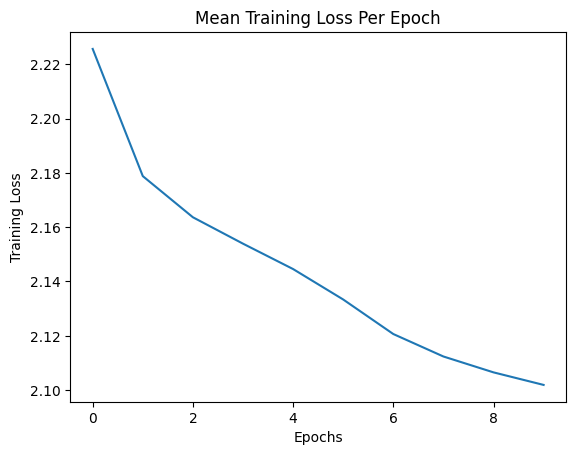

In [ ]:
#plot the training loss
plt.plot(loss_means)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Mean Training Loss Per Epoch')
plt.show()

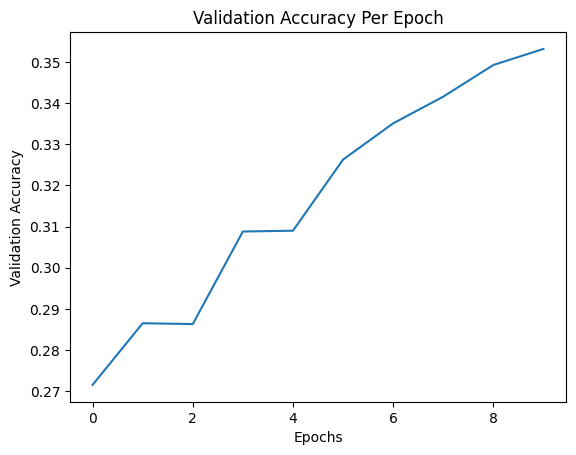

In [ ]:
#plot the validation accuracy
plt.plot(val_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Per Epoch')
plt.show()

In [ ]:
# calculate and save test accuracy
test_score = 0
for x, y_truth in test_loader:
  x, y_truth = x.to(device), y_truth.to(device)
  y_hat = model(x)
  if y_truth == y_hat.argmax(1):  # compare with greatest probability
    test_score += 1
test_accuracy = test_score / len(test_loader)
print(test_accuracy)

0.3543


# Problem 5

Write a function that loops through the test data, modifying the images as described.

Run your function for each epsilon in $[0,.05,.1,.15,.2,.25,.3]$, and plot epsilon v. accuracy.

Display the perturbed version of the first image in the test data for each epsilon.

In [ ]:
# FGSM attack code
def fgsm_attack(model, optimizer, objective, x, y, eps):
    """
    Performs the FGSM attack on the given model and data point x with label y.
    Returns the perturbed data point.
    """
    # Calculate the gradient
    x.requires_grad = True
    x.retain_grad()
    optimizer.zero_grad()
    output = model(x)
    loss = objective(output, y)
    loss.backward()
    data_grad = x.grad.data
    # Perturb the images
    x_perturbed = x + eps * data_grad.sign()
    return x_perturbed

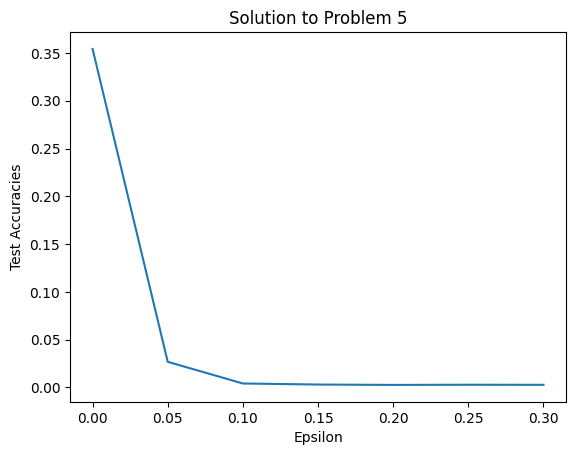

In [ ]:
#save the accuracies and create array of epsilons
test_accs = []
eps = [0, .05, .1, .15, .2, .25, .3]

#iterate through the epsilons
for ep in eps:
  test_score = 0
  #calculate the test score with the perturbed picture
  for x, y_truth in test_loader:
    x, y_truth = x.to(device), y_truth.to(device)
    ex = fgsm_attack(model, optimizer, objective, x, y_truth, ep)
    y_hat = model(ex)
    if y_truth == y_hat.argmax(1):  # compare with greatest probability
      test_score += 1

  #get the test score
  test_accuracy = test_score/len(test_loader)
  test_accs.append(test_accuracy)

#plot the results
plt.plot(eps, test_accs)
plt.title('Solution to Problem 5')
plt.xlabel('Epsilon')
plt.ylabel('Test Accuracies')
plt.show()

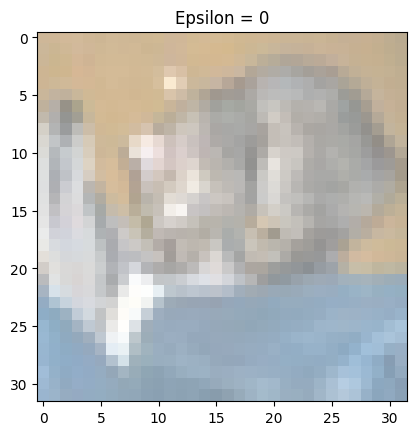

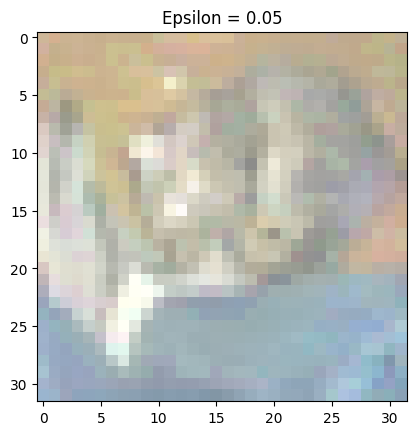

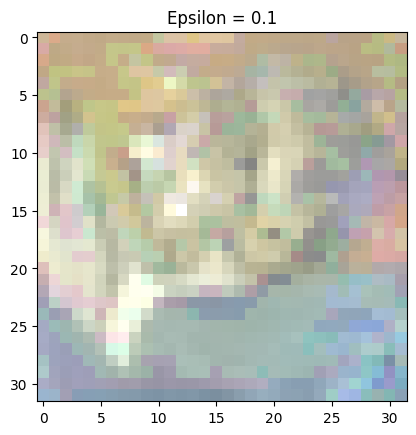

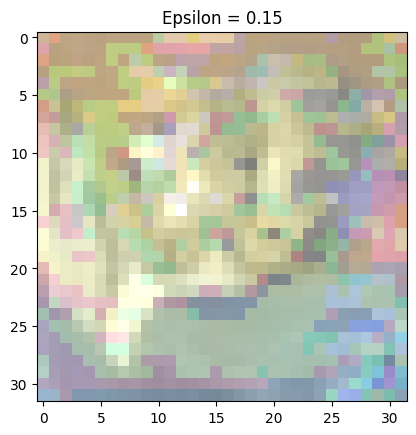

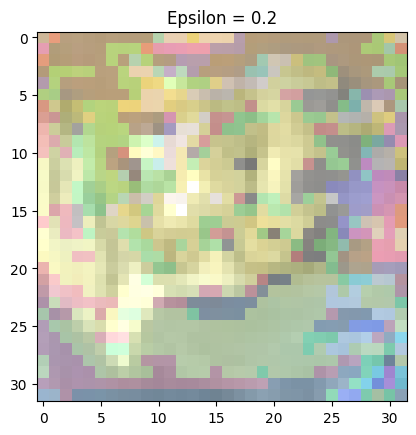

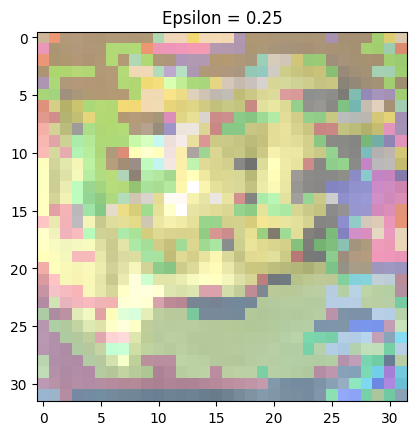

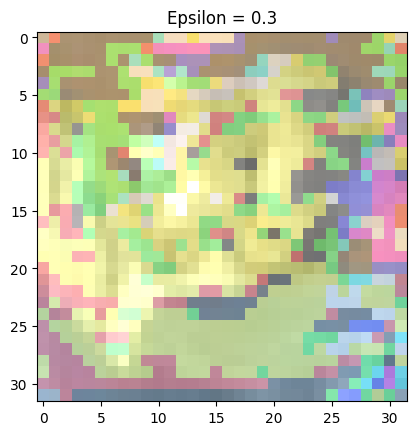

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

#display the first image in the test data for each epsilon
for ep in eps:
  perturbed = fgsm_attack(model, optimizer, objective, images, labels, ep)
  ex = perturbed.squeeze().detach().cpu().numpy()

  img = ex / 2 + 0.5 
  plt.imshow(np.transpose(img, (1,2,0)))
  plt.title('Epsilon = '+str(ep))
  plt.show()